# Global NPP Model:

In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Calculating NPP using the Lopez-Urrutia Definition:

$NPP =  \frac{1}{V}\epsilon p_o e^\frac{-E_a}{kT}\frac{I}{I+K_I}\sum\limits_{i=1}^{n_a}M_i^{\alpha_a}$

### NPP Function:

In [12]:
def NPP(T,I,M,na):
    eps = 0.83             # Photosynthetic efficiency
    p0  = np.exp(-11.28)   # Constant from Lopez-Urrutia et al
    Ea  = 0.62             # Activation Energy [eV]
    k   = 8.62*10**-5      # Boltzmann Constant [eV/K]
    ki  = 1.51             # Half Saturation for Photosynthetic Light
    alpha = 0.75           # Metabolic Scaling Term
    NPPV = eps*p0*np.exp(-Ea/(k*T))*I/(I+ki)*na*M**alpha
    return NPPV


### Diffusive Cell Size Function:

In [13]:
def Radius(T,Cinf):   
    # These constants are taken from Notebook-Diffusive-Model.ipynb

    k_b = 1.380649e-23  #Boltzmann's Constant [J K^-1]
    R = 8.617333262e-5      #Gas Constant [J K^-1 mol^-1]
    r = 3.8e-10      #Bond Length of O_2, used for molecular radius [m]
    rho = 1.15              #Density of cell, [g/ml]=[kg/l]
    b0 = np.exp(15.85)      #MTE normalization constant, value taken from unicells from J. Brown "Towards a MTE"
    b0 = 1
    Ea = 0.62               #Average activation energy according to J. Brown (converted from eV to Joules) [J]
    eta0= 0.02939e-3    #Dynamic viscosity constant of water, [Pa*s], [kg/m*s]
    A = 507.88              #Vogel equation constant for water [K]
    C = 149.3               #Vogel equation second constant for water [K]
    alpha = 1            #Exponential scaling coefficient, 3/4 for multicellular euks, 1 for unicellular euks.
    Cyield = 1.4e6
    B0 = b0*((4/3)*np.pi*rho)**alpha #Combination of constants
    
    
    aa = ((2/3)*k_b*T/(eta0*r)*np.exp(-A/(T-C))*np.exp(Ea/(R*T))*Cinf/B0)**(1/(3*alpha-1))
    return aa


### Modeling Population using Biomass model from Kempes et al. 2021:

In [14]:
# Model Parameters based on Kempes et. al 2021:
# Taken from SFI_UCR/Kempes2021Model.nb


# v functions
vmaxp = 12.3
vmaxn = 341
def vmaxnfn(v):
    vmax = 9.10e-9*(v/10**(-18))**0.67
    return vmax
puptakefac = vmaxp / vmaxn
def vmaxpfn(v):
    vmax = vmaxnfn(v) * puptakefac
    return vmax

# k functions
kp = 0.2
kn = 5.6

def Knfn(v):
    K = 0.17*(v/10**(-18))**0.27
    return K
Kpfac = kp / kn
def Kpfn(v):
    K = Knfn(v) * Kpfac
    return K

# Q functions
Qminp = 1.64
Qminn = 45.4

def Qminnfn(v):
    Qmin = 1.36e-9*(v/10**(-18))**0.77
    return Qmin
Qpfac = Qminp / Qminn
def Qminpfn(v):
    Qmin = Qminnfn(v) * Qpfac
    return Qmin

def tdfn(v):
    td = 1.488139e-8/(v**0.64548834355)
    return td
def muinffn(v):
    mu = np.log(2) / tdfn(v) *3600*24
    return mu
def muinffn2(v):
    mu = 3.4178425277911773e-9 * 3600 * 24 / (v**0.26)
    return mu

a = 0.59
def Rstar(volref):
    Rstartmp = Qminpfn(volref)*a*muinffn2(volref) *Kpfn(volref)/(vmaxpfn(volref)*(muinffn2(volref) - a) - Qminpfn(volref)*a*muinffn2(volref))    # micromol per liter
    return Rstartmp
def Nstar(volref, Rin):
    Nstartmp = a*(Rin - Rstar(volref))*(muinffn2(volref) - a)/(Qminpfn(volref)*muinffn2(volref)*a)    # Cells per Liter
    return Nstartmp


## Assumed Relationship between Temp and Relative Inorganic Nutrient Concentration

Text(0, 0.5, 'Nutrient Concentration')

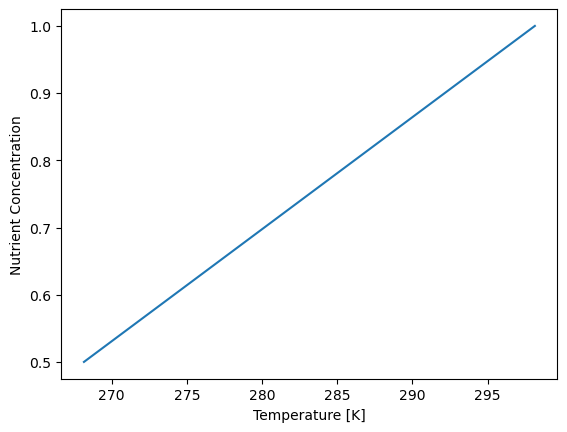

In [15]:
T = np.linspace(-5,25,100)+273.15

def Cinfinity(T):
    # Ci = (1/75)*(T-268.15)
    # Cinf = 10**(Ci)-0.5
    Cinf = (1/60)*(T-268.15)+0.5
    return Cinf
plt.plot(T,Cinfinity(T))
plt.xlabel('Temperature [K]')
plt.ylabel('Nutrient Concentration')

## NPP as a function of Temperature and Nutrient Flux:

### Constant size  and Population:

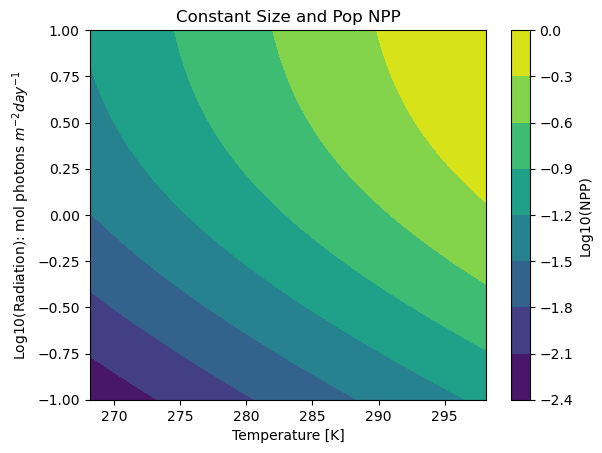

In [16]:
na = 1e5
M = 10
T = np.linspace(-5,25,400)+273.15  #Temperature [K]
nppconst = []
I = []  #Concentration of limiting nutrient far away from the organism [M_O2]
# Model Equation:

for ii in np.linspace(-1,1,400):
    i = 10**ii
    I.append(i)
    pp = NPP(T,i,M,na)
    nppconst.append(pp)
nppconst = nppconst/np.max(nppconst)

t, i = np.meshgrid(T, I)
fig, ax = plt.subplots()
cs = ax.contourf(t,np.log10(i),np.log10(nppconst),cmap='viridis')
cbar = fig.colorbar(cs)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Log10(Radiation): mol photons '+r'$m^{-2} day^{-1}$')
ax.set_title('Constant Size and Pop NPP')
cbar.ax.set_ylabel('Log10(NPP)')
plt.show()

### Constant Pop, Size varies with Temp (Nutrient Concentration is held constant):

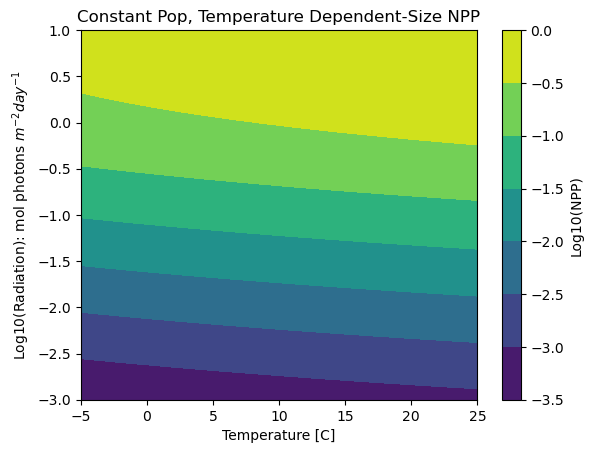

In [17]:
na = 1e5
Cinf = 1
T = np.linspace(-5,25,400)+273.15  #Temperature [K]
npptemp = []
I = []  #Concentration of limiting nutrient far away from the organism [M_O2]
# Model Equation:

for ii in np.linspace(-3,1,400):
    i = 10**ii
    I.append(i)
    aa = Radius(T,Cinf)
    M = (4/3)*np.pi*aa**3
    pp = NPP(T,i,M,na)
    npptemp.append(pp)

npptemp = npptemp/np.max(npptemp)

cmin = np.min(np.log10(npptemp))
cmax = np.max(np.log10(npptemp))
levels = np.linspace(-3.5,cmax,11)

t, i = np.meshgrid(T-273.15, I)
fig, ax = plt.subplots()
cs = ax.contourf(t,np.log10(i),np.log10(npptemp),cmap='viridis')
cbar = fig.colorbar(cs)
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Log10(Radiation): mol photons '+r'$m^{-2} day^{-1}$')
ax.set_title('Constant Pop, Temperature Dependent-Size NPP')
cbar.ax.set_ylabel('Log10(NPP)')
plt.show()

### Constant Population, Size Varies with Temp and Nutrients:

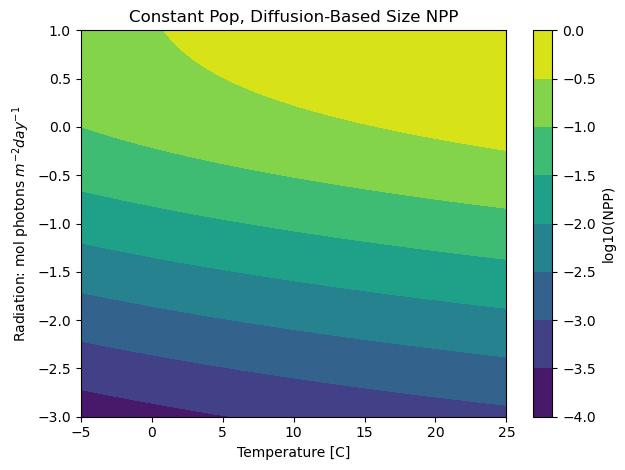

In [18]:
#NPP calculation with size varying with temperature based on diffusion model. Number of autotrophs is constant
na = 1e5
T = np.linspace(-5,25,400)+273.15  #Temperature [K]
nppdifs = []
I = []  #Concentration of limiting nutrient far away from the organism [M_O2]

cmax = []

# Model Equation:
for ii in np.linspace(-3,1,400):
    i = 10**ii
    I.append(i)
    nppdif = []
    for Ti in T:
        Cinf = Cinfinity(Ti)
        aa = Radius(Ti,Cinf)
        M = (4/3)*np.pi*aa**3
        pp = NPP(Ti,i,M,na)
        nppdif.append(pp)
    cmax.append(np.max(nppdif))
    nppdifs.append(nppdif)
T = T-273.15
cmax = np.max(cmax)
nppdifs = nppdifs/cmax


t, i = np.meshgrid(T, I)
fig, ax = plt.subplots()
cs = ax.contourf(t,np.log10(i),np.log10(nppdifs))
cbar = fig.colorbar(cs)
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Radiation: mol photons '+r'$m^{-2} day^{-1}$')
cbar.ax.set_ylabel('log10(NPP)')
plt.title('Constant Pop, Diffusion-Based Size NPP')
plt.tight_layout()
plt.show()

### Const Size, Pop based on Kempes Biomass Model:

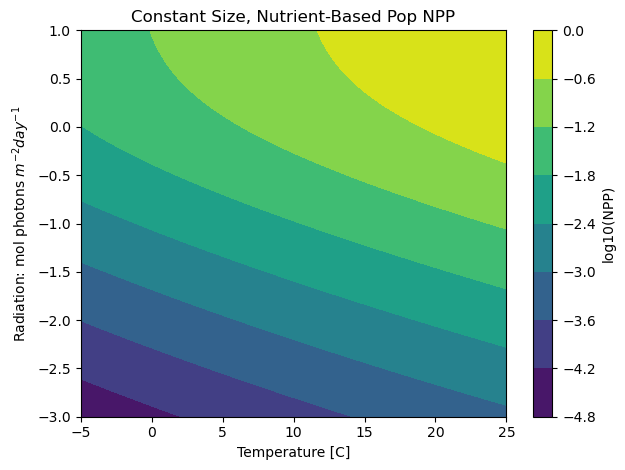

In [19]:
radius = 10**-6.5
T = np.linspace(-5,25,400)+273.15  #Temperature [K]
npppops = []
I = []  #Concentration of limiting nutrient far away from the organism [M_O2]

cmax = []
Numss = []

# Model Equation:
for ii in np.linspace(-3,1,400):
    i = 10**ii
    I.append(i)
    npppop = []
    Nums = []
    for Ti in T:
        Cinf = Cinfinity(Ti)
        v = (4/3)*np.pi*radius**3
        Num = Nstar(v,Cinf)
        Nums.append(Num)
        na = Num/(v*1.15)
        pp = NPP(Ti,i,v,na)
        npppop.append(pp)
    cmax.append(np.max(npppop))
    npppops.append(npppop)
    Numss.append(Nums)
T = T-273.15
cmaxs = np.max(cmax)
npppops = npppops/cmaxs


t, i = np.meshgrid(T, I)
fig, ax = plt.subplots()
cs = ax.contourf(t,np.log10(i),np.log10(npppops))
cbar = fig.colorbar(cs)
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Radiation: mol photons '+r'$m^{-2} day^{-1}$')
cbar.ax.set_ylabel('log10(NPP)')
plt.title("Constant Size, Nutrient-Based Pop NPP")
plt.tight_layout()
plt.show()



## Final Subplot:

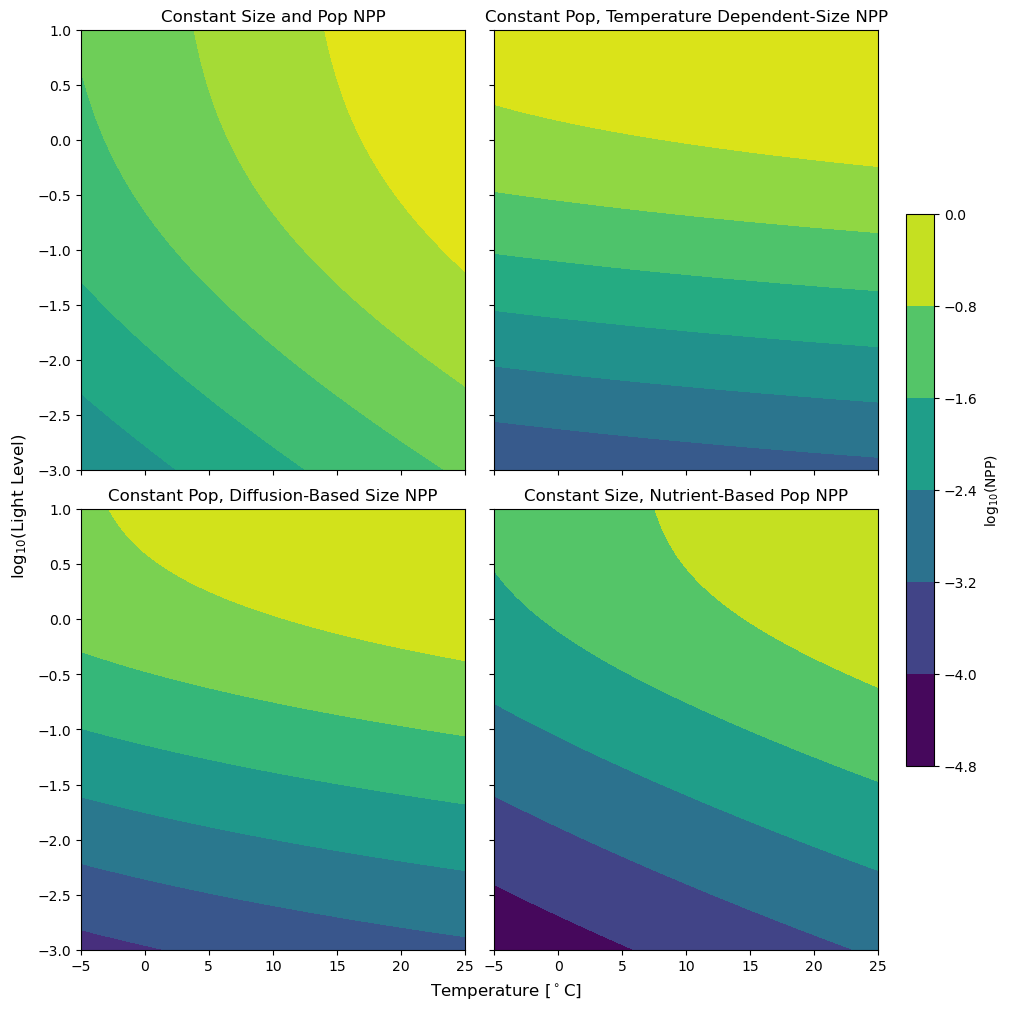

In [20]:
t, i = np.meshgrid(T, I)
fig, axs = plt.subplots(2,2,figsize=(10,10),layout='constrained',sharex=True,sharey=True,width_ratios=[1,1])

cs = axs[0,0].contourf(t,np.log10(i),np.log10(nppconst),vmin=-4.5,vmax=0,levels=6,cmap='viridis')

cstemp = axs[0,1].contourf(t,np.log10(i),np.log10(npptemp),vmin=-4.5,vmax=0,levels=6,cmap='viridis')

csdif = axs[1,0].contourf(t,np.log10(i),np.log10(nppdifs),vmin=-4.5,vmax=0,levels=6,cmap='viridis')

cspop = axs[1,1].contourf(t,np.log10(i),np.log10(npppops),vmin=-4.5,vmax=0,levels=6,cmap='viridis')

axs[0,0].set_title('Constant Size and Pop NPP')
axs[0,1].set_title('Constant Pop, Temperature Dependent-Size NPP')
axs[1,0].set_title('Constant Pop, Diffusion-Based Size NPP')
axs[1,1].set_title('Constant Size, Nutrient-Based Pop NPP')
fig.supxlabel(r'Temperature [$^\circ$C]')
fig.supylabel(r'log$_{10}$(Light Level)')
cbar = fig.colorbar(cspop,ax = axs[:,1],shrink=0.6)
cbar.ax.set_ylabel(r'log$_{10}$(NPP)')
plt.show()